In [56]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Make the scroll window slightly larger
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 30em; }</style>"))

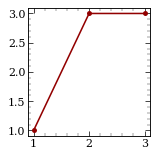

In [57]:
import sys
import os
# top_path = '..'
# if top_path not in sys.path:
#     sys.path.append(top_path)

# coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
# if coffea_path not in sys.path:
#     sys.path.insert(0,coffea_path)
    
# ak_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/local-packages/'

# if ak_path not in sys.path:
#     sys.path.insert(0,ak_path)
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from helpers import hist_mult
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle('hep')

#### some newer versions of pyplot and mplhep, aren't good friends with jupyter
#### To make the plots be formatted directly well, we need to make a dummy plot and rerun the import
### (a very silly solution)
plt.figure(num=None, figsize=(2, 2), dpi=80)
plt.plot([1,2,3],[1,3,3])
import matplotlib.pyplot as plt
pltStyle('hep') #, font_frac=1.35
# from collections.abc import Iterable
# %matplotlib notebook 
# %matplotlib notebook
1;

In [58]:
from helpers import sum_neg_pos_eta, rebin_hist, get_xsec_dict, get_flavor_antiflavor_list
from JetEtaBins import JetEtaBins, PtBins

from fileNames.available_datasets import dataset_dictionary

from uncertainty_helpers import get_output, sum_output, combine_flavors, get_spline, FlavorFractions, create_data_HerPy_differences
from uncertainty_plotters import plot_Efractions, plot_Efractions_ratio, plot_spectra, plot_ratio_comparisons_samples, plot_HerPydiff, plot_uncertainty, plot_uncertainty_antiflav

from uncertainty_helpers import get_ratio, read_data2, read_corrections, ptmin_global, ptmax_global
# from uncertainty_helpers import get_evaluator_limits, get_evaluator_limits_all_flav
from RatioPlotFitRes import RatioPlotFitRes, CorrectionEvaluator, get_additional_uncertainty_curves
from scipy.interpolate import RegularGridInterpolator 

# from common_binning import JERC_Constants

In [59]:
use_corrections = 'ratio' ### Which corrections to use for deriving the uncertainties 'T' for ttbar, 'J' for QCD, 'ratio' for the combined ratio fit
### If to include unmatched in calculating the uncertainties with seperate fits and
### include them in the flavor fraction plots.
### If False, unmatched are ignored
include_unmatched = True
combine_antiflavour = True
combine_antiflavour_txt = '_split_antiflav' if not combine_antiflavour else ''
add_composed_flav = True # if to also provide uncertainty for q as ud+s

eta_binning  = "HCalPart"  ### HCalPart, CoarseCalo, CaloTowers, one_bin, Summer20Flavor;       
                         ### HCalPart: bin in HCal sectors, CaloTowers: the standard JERC binning,
                         ### CoarseCalo: like 'CaloTowers' but many bins united;

In [60]:
jeteta_bins = JetEtaBins(eta_binning, absolute=True)
pt_bins = PtBins("MC_truth")
eta_binning_str = '_'+eta_binning if eta_binning != "HCalPart" else ''

In [61]:
if not combine_antiflavour and use_corrections == 'ratio':
    raise ValueError("Ratio results are not yet supported for the flavor/antiflavor uncertainty")

### Sum together all the different flavors and
### Get the splines of the flavor fractions

In [62]:
QCD_xsec = 1373000000 

In [63]:
# sample_plot

Saving plot with the name =  fig/pt_spectra/pt_spectra_QCD-Py_genwt_test_QCD-MG-Py_QCD-MG-Her_QCD-Py


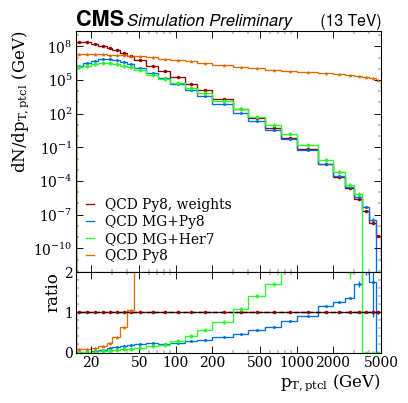

In [64]:
from fileNames.available_datasets import legend_labels

eta_idx = jeteta_bins.get_bin_idx(0)
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']

Her_legends = ['QCD MG+Her7', 'DY MG+Her7', legend_labels["ttbar"]["lab"]+' Pow+Her7']
Py_legends = ['QCD MG+Py8', 'DY MG+Py8', legend_labels["ttbar"]["lab"]+' Pow+Py8']
# samples = ['QCD', 'DY', 'TTBAR']
# Her_samples = ['_QCD-MG-Py_3rd_jet', '_DY-MG-Her', '_Herwig-TTBAR']
# Py_samples = ['_QCD-Py_3rd_jet', '_DY-MG-Py', '_Pythia-TTBAR'] #_sel_67ac6c3

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
# qfrac_spline_dict2 = {}
qfrac_spline_dict2D = {}
legend_labels = []
flavors = ['g', 'c', 'b', 'ud', 's', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'ud', 's']
if not combine_antiflavour:
    flavors = get_flavor_antiflavor_list(flavors)
flavors_to_obtain = flavors+['all'] if include_unmatched==True else flavors
    
saveplot = include_unmatched if combine_antiflavour else True

# for ii in range(len(samples)):
for ii in range(1):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    legenddict = {sampPy:Py_legends[ii], sampHer:Her_legends[ii] }
    samp = samples[ii]
    sample_plot = {}
    hists_rebinned_dict = {}
    Neffs = {}
    
#     for sample in [sampPy, sampHer]:
#     for sample in ['QCD-Py_genwt', 'QCD-MG-Py', 'QCD-Py']:
    for sample in ['QCD-Py_genwt_test', 'QCD-MG-Py', 'QCD-MG-Her', 'QCD-Py']:
#         print(sample)
        output = get_output(sample)
        file_dict, legend_label = get_xsec_dict(sample, dataset_dictionary)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, flavors_to_obtain, sumeta=False, combine_antiflavour=combine_antiflavour)
#         check_bins(hists[flavors[0]], jeteta_bins, pt_bins)
        Neffs[sample] = output['sum_weights']['sum_weights'].value
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', jeteta_bins.edges) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])
        hists_rebinned_dict[sample] = hists_rebinned
        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values().copy()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        qfrac_var_all = hists_rebinned['all'].variances()/hists_vals['all']**2
        qfrac_var = {}
        for flav in flavors:
            qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var_all**2)
        Efrac_splines = {key: 
                         np.array([get_spline(qfracs[key][:,eta_idx], pt_bins) 
                          for eta_idx in range(jeteta_bins.nbins)
                         ])
                        for key in qfracs.keys()
                        }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(pt_bins.centres), jeteta_bins.centres), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]

#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        zero_spline = get_spline(np.array([1e-15]*pt_bins.nbins), pt_bins)
        if add_composed_flav:
            Efrac_splines['q'] = np.array([zero_spline]*jeteta_bins.nbins)
            if not combine_antiflavour:
                Efrac_splines['qbar'] = np.array([zero_spline]*jeteta_bins.nbins)
            qfrac_spline_dict[sample] = FlavorFractions(Efrac_splines, eta_binning) #Efrac_splines #Efrac_2Dsplines
#         qfrac_spline_dict2[sample] = Efrac_splines
        
        qfrac_spline_dict2D[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]
        legend_labels.append(legend_label) if sample != 'QCD-Py_genwt_test' else legend_labels.append(legend_label+', weights')

    ### to make
    hists_rebinned_dict['QCD-MG-Her'] = hist_mult(hists_rebinned_dict['QCD-MG-Her'], Neffs['QCD-MG-Py']/Neffs['QCD-MG-Her'])
    plot_spectra(hists_rebinned_dict, legend_labels, 'all', eta_idx, jeteta_bins, pt_bins, saveplot=True, plotvspt=True)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}

if add_composed_flav:
    flavors=flavors[:3]+['q']+flavors[3:] if combine_antiflavour else flavors+['q', 'qbar'] 

In [65]:
# Neffs['QCD-Py_genwt_test']

In [66]:
from save_json import save_json_fractions

Saving plot with the name =  fig/fractions/fraction_eta0p0to1p305_QCD-MG-Her_QCD-MG-Py
Saving plot with the name =  fig/fractions/fraction_eta1p305to2p5_QCD-MG-Her_QCD-MG-Py
Saving plot with the name =  fig/fractions/fraction_eta2p5to3p139_QCD-MG-Her_QCD-MG-Py
Saving plot with the name =  fig/fractions/fraction_eta3p139to5p191_QCD-MG-Her_QCD-MG-Py
Saved out_txt/flavor_fractions_QCD-MG-Her_QCD-MG-Py.json
Saving plot with the name =  fig/fractions/fraction_eta0p0to1p305_DY-MG-Her_DY-MG-Py
Saving plot with the name =  fig/fractions/fraction_eta1p305to2p5_DY-MG-Her_DY-MG-Py
Saving plot with the name =  fig/fractions/fraction_eta2p5to3p139_DY-MG-Her_DY-MG-Py
Saving plot with the name =  fig/fractions/fraction_eta3p139to5p191_DY-MG-Her_DY-MG-Py
Saved out_txt/flavor_fractions_DY-MG-Her_DY-MG-Py.json
Saving plot with the name =  fig/fractions/fraction_eta0p0to1p305_Herwig-TTBAR_Pythia-TTBAR
Saving plot with the name =  fig/fractions/fraction_eta1p305to2p5_Herwig-TTBAR_Pythia-TTBAR
Saving plot 

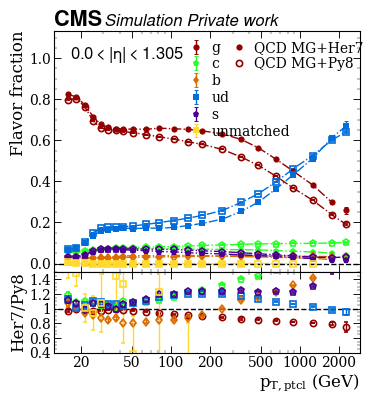

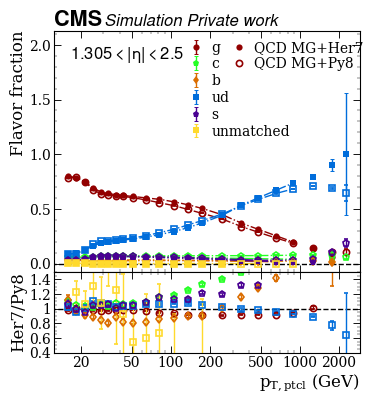

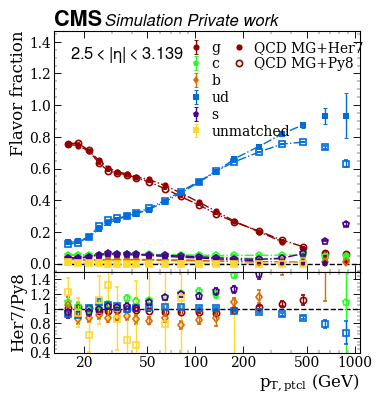

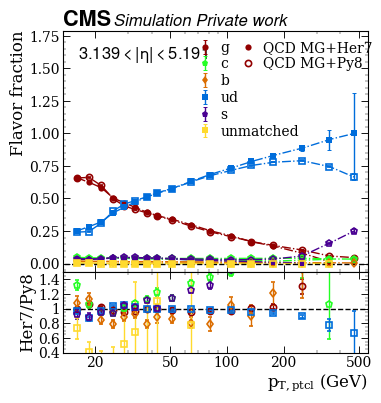

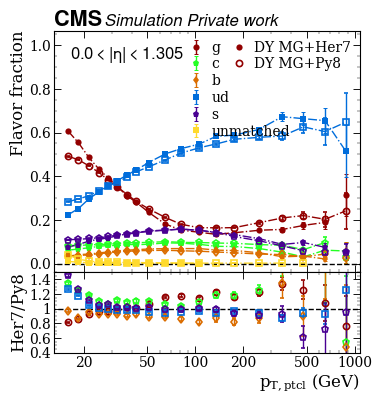

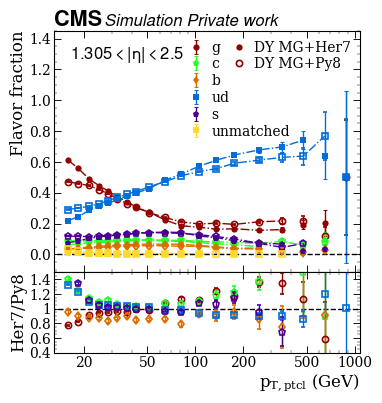

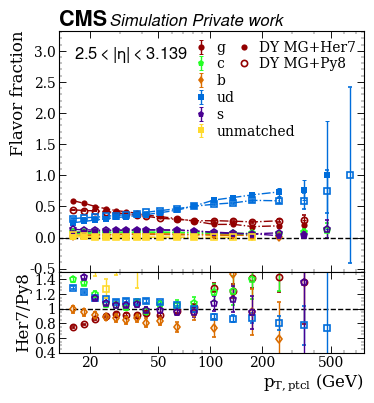

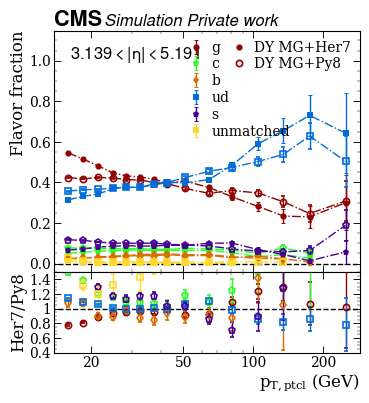

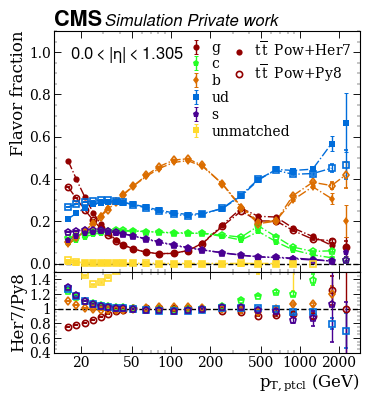

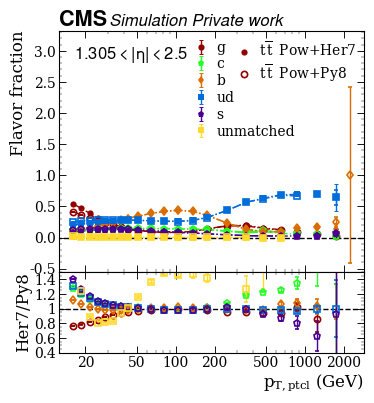

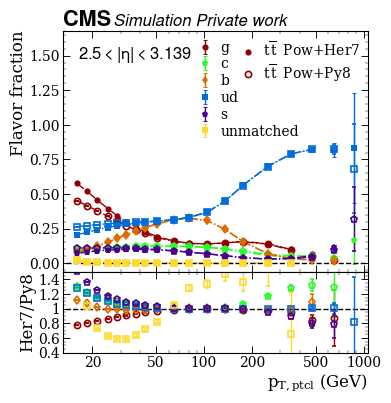

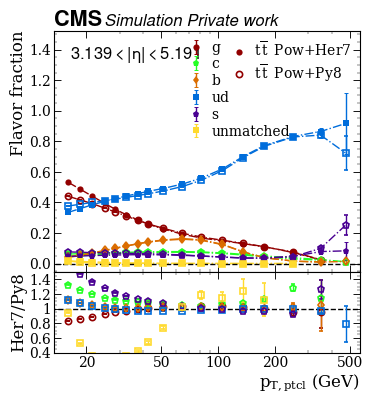

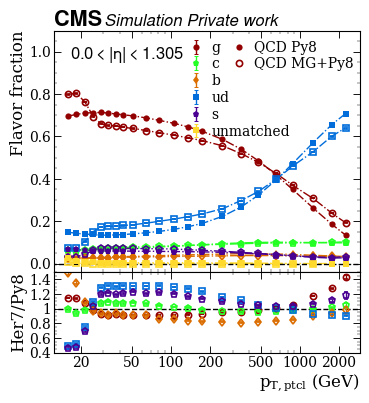

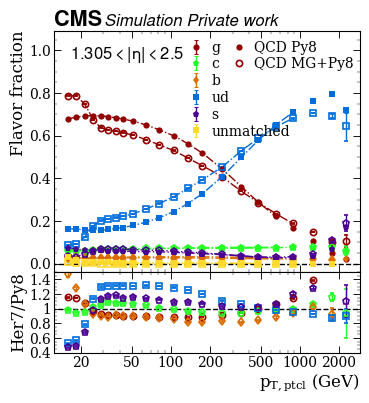

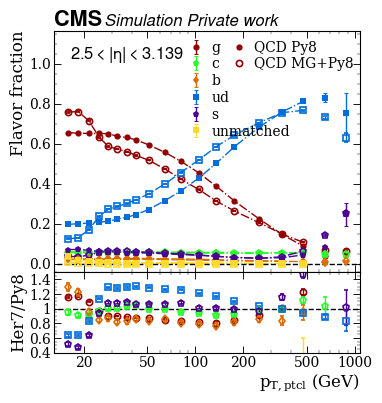

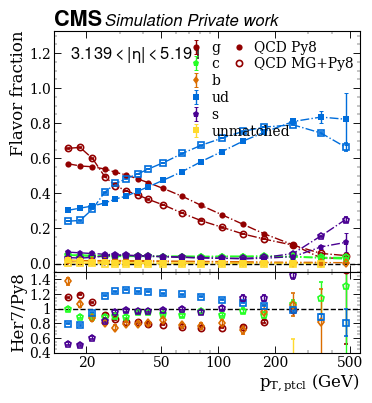

In [67]:
from fileNames.available_datasets import legend_labels

eta_idx = jeteta_bins.get_bin_idx(0)
ndraw = jeteta_bins.nbins if include_unmatched==True else 1
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']

Her_legends = ['QCD MG+Her7', 'DY MG+Her7', legend_labels["ttbar"]["lab"]+' Pow+Her7']
Py_legends = ['QCD MG+Py8', 'DY MG+Py8', legend_labels["ttbar"]["lab"]+' Pow+Py8']

if include_unmatched==True:
    Her_samples+=['QCD-Py']
    Her_legends+=['QCD Py8']
    Py_samples+=['QCD-MG-Py']
    Py_legends+=['QCD MG+Py8']
    samples+=['QCD_stand']
# samples = ['QCD', 'DY', 'TTBAR']
# Her_samples = ['_QCD-MG-Py_3rd_jet', '_DY-MG-Her', '_Herwig-TTBAR']
# Py_samples = ['_QCD-Py_3rd_jet', '_DY-MG-Py', '_Pythia-TTBAR'] #_sel_67ac6c3

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
# qfrac_spline_dict2 = {}
qfrac_spline_dict2D = {}
legend_labels = []
flavors = ['g', 'c', 'b', 'ud', 's', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'ud', 's']
# flavors = ['g', 'cs', 'b', 'ud', 'unmatched']
if not combine_antiflavour:
    flavors = get_flavor_antiflavor_list(flavors)
flavors_to_obtain = flavors+['all'] if include_unmatched==True else flavors
    
saveplot = include_unmatched if combine_antiflavour else True

for ii in range(len(samples)):
# for ii in range(1):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    legenddict = {sampPy:Py_legends[ii], sampHer:Her_legends[ii] }
    samp = samples[ii]
    sample_plot = {}
    hists_rebinned_dict = {}
    
    for sample in [sampHer, sampPy]:
#     for sample in ['QCD-Py_genwt', 'QCD-MG-Py', 'QCD-Py']:
        output = get_output(sample)
        file_dict, legend_label = get_xsec_dict(sample, dataset_dictionary)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, flavors_to_obtain, sumeta=False, combine_antiflavour=combine_antiflavour)
#         check_bins(hists[flavors[0]], jeteta_bins, pt_bins)
            
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', jeteta_bins.edges) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])
        hists_rebinned_dict[sample] = hists_rebinned
        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values().copy()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        qfrac_var_all = hists_rebinned['all'].variances()/hists_vals['all']**2
        qfrac_var = {}
        for flav in flavors:
            qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var_all**2)
        Efrac_splines = {key: 
                         np.array([get_spline(qfracs[key][:,eta_idx], pt_bins) 
                          for eta_idx in range(jeteta_bins.nbins)
                         ])
                        for key in qfracs.keys()
                        }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(pt_bins.centres), jeteta_bins.centres), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]

#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        zero_spline = get_spline(np.array([1e-15]*pt_bins.nbins), pt_bins)
        if add_composed_flav:
            Efrac_splines['q'] = np.array([zero_spline]*jeteta_bins.nbins)
            if not combine_antiflavour:
                Efrac_splines['qbar'] = np.array([zero_spline]*jeteta_bins.nbins)
            qfrac_spline_dict[sample] = FlavorFractions(Efrac_splines, eta_binning) #Efrac_splines #Efrac_2Dsplines
#         qfrac_spline_dict2[sample] = Efrac_splines
        
        qfrac_spline_dict2D[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]
        legend_labels.append(legend_label) if sample != 'QCD-Py_genwt' else legend_labels.append(legend_label+', weights')

    for eta_idx in range(ndraw):
#         plot_Efractions(sample_plot, eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, saveplot=saveplot)
        plot_Efractions_ratio(sample_plot, eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, saveplot=saveplot)
#     hists_rebinned_dict['QCD-Py_genwt'] = hist_mult(hists_rebinned_dict['QCD-Py_genwt'],QCD_xsec)
#     hists_rebinned_dict['QCD-Py'] = hist_mult(hists_rebinned_dict['QCD-Py'],QCD_xsec)
#     plot_spectra(hists_rebinned_dict, legend_labels, 'all', eta_idx, jeteta_bins, pt_bins, saveplot=True, plotvspt=True)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}
    if saveplot:
        json_filename = 'out_txt/flavor_fractions_'+'_'.join([sampHer, sampPy])+eta_binning_str+'.json'
        save_json_fractions(sample_plot, pt_bins, jeteta_bins, json_filename)

if add_composed_flav:
    flavors=flavors[:3]+['q']+flavors[3:] if combine_antiflavour else flavors+['q', 'qbar'] 

In [81]:
# import json
# with open('out_txt/response_fit_results_L5_DY-MG-Her.json', 'r') as json_file:
#     json_data = json.load(json_file)
    
# json_data

# Deriving the uncertainties

In [82]:
# from fileNames.available_datasets import legend_labels

# eta_idx = jeteta_bins.get_bin_idx(0)
# samples = ['QCD', 'DY', 'TTBAR']
# Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
# Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-semilep-TTBAR']

# Her_legends = ['QCD MG+Her7', 'DY MG+Her7', legend_labels["ttbar"]["lab"]+' Pow+Her7']
# Py_legends = ['QCD MG+Py8', 'DY MG+Py8', legend_labels["ttbar"]["lab"]+' Pow+Py8']
# # samples = ['QCD', 'DY', 'TTBAR']
# # Her_samples = ['_QCD-MG-Py_3rd_jet', '_DY-MG-Her', '_Herwig-TTBAR']
# # Py_samples = ['_QCD-Py_3rd_jet', '_DY-MG-Py', '_Pythia-TTBAR'] #_sel_67ac6c3

# qfrac_dict = {}
# qfrac_var_dict = {}
# qfrac_spline_dict = {}
# # qfrac_spline_dict2 = {}
# qfrac_spline_dict2D = {}
# legend_labels = []
# flavors = ['g', 'c', 'b', 'ud', 's', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'ud', 's']
# if not combine_antiflavour:
#     flavors = get_flavor_antiflavor_list(flavors)
# flavors_to_obtain = flavors+['all'] if include_unmatched==True else flavors
    
# saveplot = include_unmatched if combine_antiflavour else True

# # for ii in range(len(samples)):
# for ii in range(1):
#     sampHer = Her_samples[ii]
#     sampPy = Py_samples[ii]
#     legenddict = {sampPy:Py_legends[ii], sampHer:Her_legends[ii] }
#     samp = samples[ii]
#     sample_plot = {}
#     hists_rebinned_dict = {}
#     Neffs = {}
    
# #     for sample in [sampHer, sampPy]:
#     for sample in ['QCD-Py_genwt_test', 'QCD-MG-Py_test', 'QCD-MG-Her_test', 'QCD-Py_test']:
#         output = get_output(sample)
#         file_dict, legend_label = get_xsec_dict(sample, dataset_dictionary)
#         output = sum_output(output, sample, file_dict)
#         Neffs[sample] = output['N_ev_effective']['N_ev_effective'].value
#         hists = combine_flavors(output, flavors_to_obtain, sumeta=False, combine_antiflavour=combine_antiflavour)
# #         check_bins(hists[flavors[0]], jeteta_bins, pt_bins)
            
#         hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', jeteta_bins.edges) for flav in hists.keys() }
#         if include_unmatched==False: #recalculate the all
#             hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])
#         hists_rebinned_dict[sample] = hists_rebinned
#         hists_vals = {}
#         for flav in hists_rebinned.keys():
#             vals = hists_rebinned[flav].values().copy()
#             vals[vals==0] = np.nan
#             hists_vals[flav] = vals
#         qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
# #         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
#         qfrac_var = {'all': hists_rebinned['all'].variances()/hists_vals['all']**2}
#         for flav in flavors:
#             qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var['all']**2)
#         Efrac_splines = {key: 
#                          np.array([get_spline(qfracs[key][:,eta_idx], pt_bins) 
#                           for eta_idx in range(jeteta_bins.nbins)
#                          ])
#                         for key in qfracs.keys()
#                         }
#         Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(pt_bins.centres), jeteta_bins.centres), qfracs[key], fill_value=None) 
#                           for key in qfracs.keys()}
        
# #         yval = qfracs['g'][:,0]

# #         Efrac_fit_dict[sample] = Efrac_fits
#         qfrac_dict[sample] = qfracs
#         qfrac_var_dict[sample] = qfrac_var
#         zero_spline = get_spline(np.array([1e-15]*pt_bins.nbins), pt_bins)
#         if add_composed_flav:
#             Efrac_splines['q'] = np.array([zero_spline]*jeteta_bins.nbins)
#             if not combine_antiflavour:
#                 Efrac_splines['qbar'] = np.array([zero_spline]*jeteta_bins.nbins)
#             qfrac_spline_dict[sample] = FlavorFractions(Efrac_splines, eta_binning) #Efrac_splines #Efrac_2Dsplines
# #         qfrac_spline_dict2[sample] = Efrac_splines
        
#         qfrac_spline_dict2D[sample] = Efrac_2Dsplines
#         sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]
#         legend_labels.append(legend_label) if sample != 'QCD-Py_genwt_test' else legend_labels.append(legend_label+', weights')

# #     plot_Efractions(sample_plot, eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, saveplot=saveplot)
#     hists_rebinned_dict = {samp: hist_mult(hists_rebinned_dict[samp], 1/Neffs[samp]) for samp in  ['QCD-Py_genwt_test', 'QCD-MG-Py_test', 'QCD-MG-Her_test', 'QCD-Py_test']}
#     hists_rebinned_dict['QCD-Py_genwt_test'] = hist_mult(hists_rebinned_dict['QCD-Py_genwt_test'], 1/QCD_xsec*3000)
#     hists_rebinned_dict['QCD-Py_test'] = hist_mult(hists_rebinned_dict['QCD-Py_test'],1/QCD_xsec*3000)
# #     hists_rebinned_dict['QCD-MG-Py'] = hist_mult(hists_rebinned_dict['QCD-MG-Py'], 0.0005120902740462117)
# #     hists_rebinned_dict['QCD-MG-Her'] = hist_mult(hists_rebinned_dict['QCD-MG-Her'], 0.7146647797629577)
#     plot_spectra(hists_rebinned_dict, legend_labels, 'all', eta_idx, jeteta_bins, pt_bins, saveplot=True, plotvspt=True)
# #         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}

# if add_composed_flav:
#     flavors=flavors[:3]+['q']+flavors[3:] if combine_antiflavour else flavors+['q', 'qbar'] 

### Resum all the flavors for each sample

Put here the location of the new fits

In [83]:
correction_txt_dir = 'Summer20UL18_V2_MC/'
unc_eta_str = '_'+eta_binning if eta_binning != "Summer20Flavor" else ''
correction_txt = f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs'#+combine_antiflavour_txt
correction_txt_simfit = f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit'#+combine_antiflavour_txt

In [84]:
from coffea.lookup_tools import extractor
plotsimfit = True
#### Read the fitted corrections
evaluator_names = {
    'Sum20Py': f'{correction_txt}{unc_eta_str}',
    'Sum20Her': f'{correction_txt}{unc_eta_str}_Her',
    'Sum20Py_simfit': f'{correction_txt}_standalonePy_simfit{unc_eta_str}', #
    'Sum20Her_simfit': f'{correction_txt}_simfit{unc_eta_str}_Her',
}

ext = extractor()
corr_loc_Sum20_Py = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Py']}.txt"]
corr_loc_Sum20_Her = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Her']}.txt"]

if plotsimfit:
    corr_loc_Sum20_Py_simfit = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Py_simfit']}.txt"]
    corr_loc_Sum20_Her_simfit = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Her_simfit']}.txt"]
    ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her+corr_loc_Sum20_Py_simfit+corr_loc_Sum20_Her_simfit)
else:
    ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
ext.finalize()
evaluator = ext.make_evaluator()

In [85]:
correction_txt = correction_txt+unc_eta_str
correction_txt_simfit = correction_txt_simfit+unc_eta_str

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to1p305


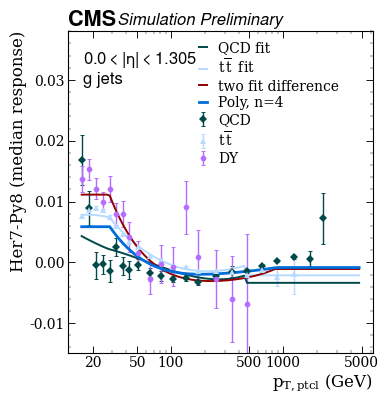

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p305to2p5


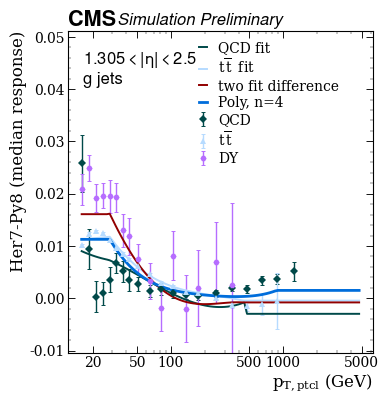

/tmp/anpotreb/ipykernel_22554/1425443478.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to1p305


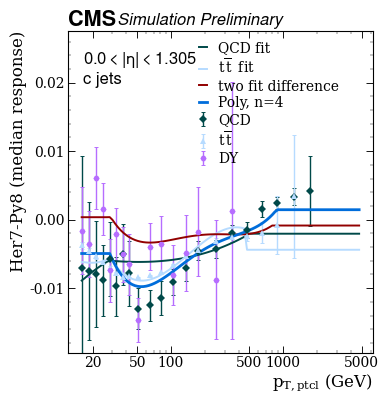

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p305to2p5


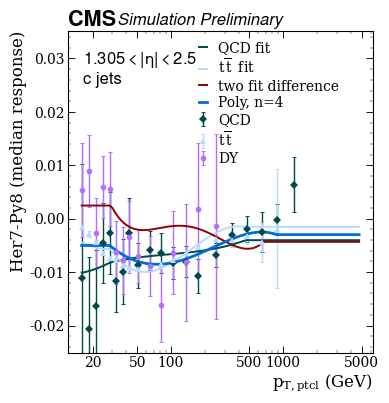

/tmp/anpotreb/ipykernel_22554/1425443478.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to1p305


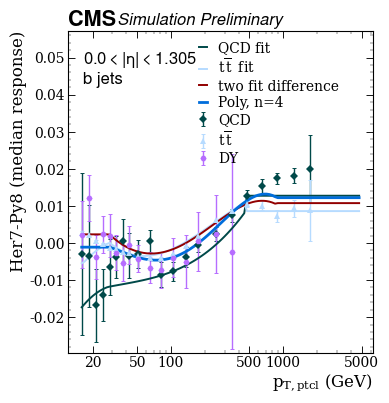

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p305to2p5


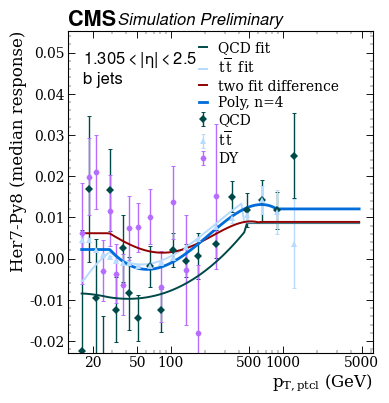

/tmp/anpotreb/ipykernel_22554/1425443478.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta0p0to1p305


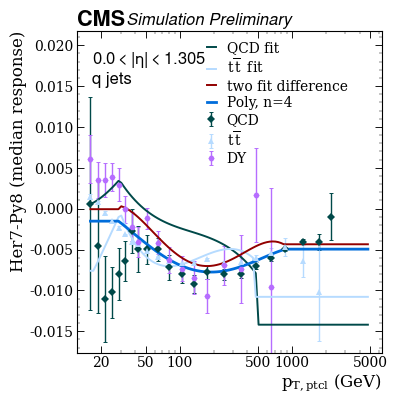

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta1p305to2p5


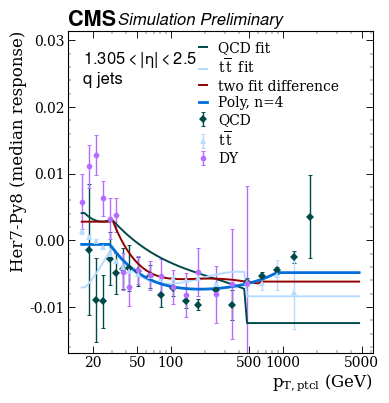

/tmp/anpotreb/ipykernel_22554/1425443478.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta0p0to1p305


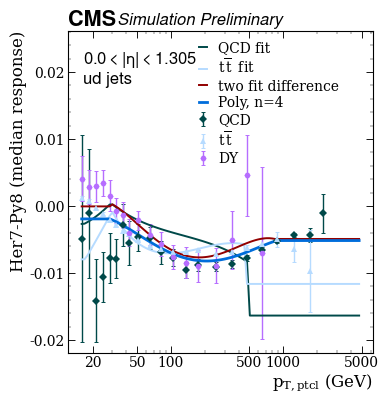

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta1p305to2p5


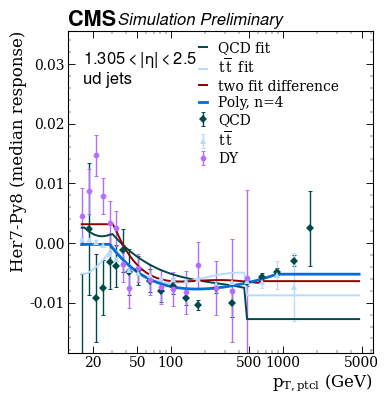

/tmp/anpotreb/ipykernel_22554/1425443478.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta0p0to1p305


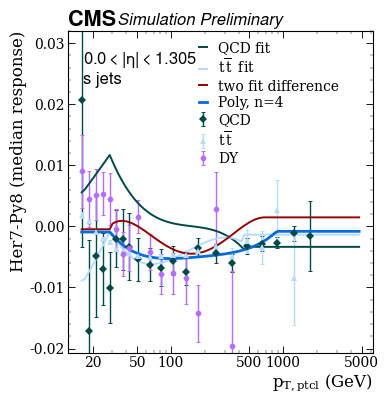

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta1p305to2p5


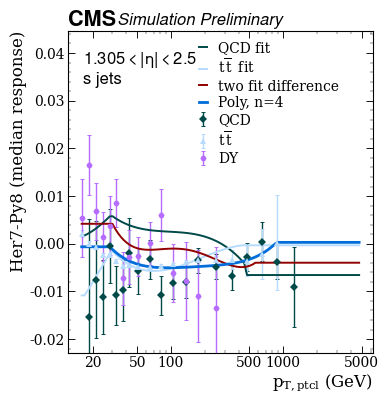

/tmp/anpotreb/ipykernel_22554/1425443478.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,


KeyError: 'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_HCalPart_Her_unmatchedJ'

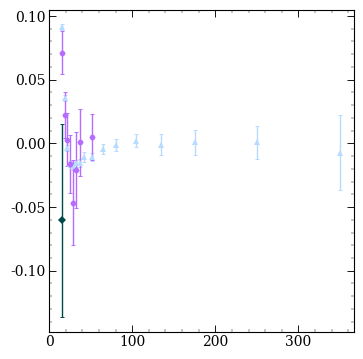

In [87]:
if use_corrections == 'ratio': #combine_antiflavour:
    ratio_fits = {}
    Her_Py_ratio_fit_res = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
    for flav in flavors:
#     for flav in ['b']:
        fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,
                                                              evaluator=evaluator, evaluator_names=evaluator_names, plotsimfit=True,
                                                              plotcorrectionratios=True) 
                                    for etaidx in range(2)]) #jeteta_bins.nbins range(2)]) #
        Her_Py_ratio_fit_res.add_flavor(flav, fit_res_tmp)

In [37]:
# if use_corrections == 'ratio': #combine_antiflavour:
#     ratio_fits = {}
#     Her_Py_ratio_fit_res = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
#     for flav in flavors:
# #     for flav in ['b']:
#         fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,
#                                                               evaluator=evaluator, evaluator_names=evaluator_names, plotsimfit=True) 
#                                     for etaidx in range(jeteta_bins.nbins)]) #range(2)]) #
#         Her_Py_ratio_fit_res.add_flavor(flav, fit_res_tmp)

### Read in the old Run1 flavor uncertainties to plot

In [38]:
from coffea.lookup_tools import extractor
# unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor.junc.txt"]
unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.junc.txt"]

ext = extractor()
ext.add_weight_sets(unc)
ext.finalize()
flav_evaluator = ext.make_evaluator()

lab_to_flav = {"DY" : "FlavorZJet",
               "QCD": "FlavorQCD",
               "GammaJet": "FlavorPhotonJet",
               "q":   "FlavorPureQuark",
               "c":   "FlavorPureCharm",
               "b":   "FlavorPureBottom",
               "g":   "FlavorPureGluon",
               }

# def get_uncertainties():
# uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_{lab_to_flav[key]}']
#                    for key in lab_to_flav}
uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_{lab_to_flav[key]}']
                   for key in lab_to_flav}

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_QCD_fit_eta0p0to1p305.pdf / .png


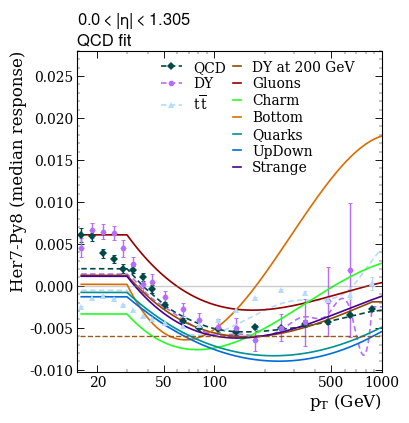

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_00eta1305_QCD_fit.pdf / .png


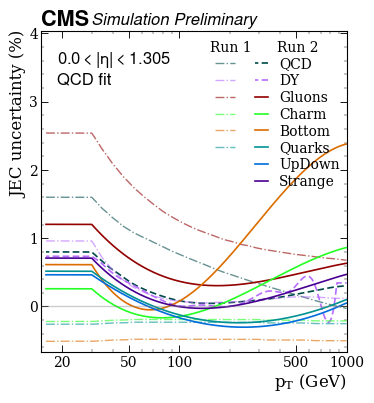

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_QCD_fit_eta1p305to2p5.pdf / .png


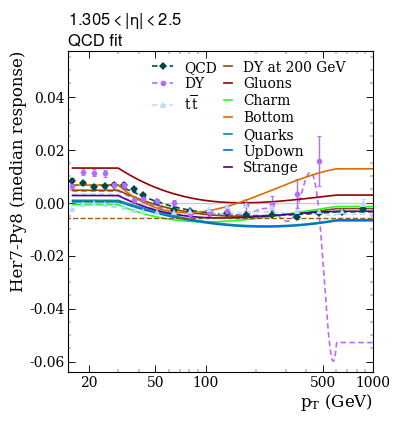

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_1305eta25_QCD_fit.pdf / .png


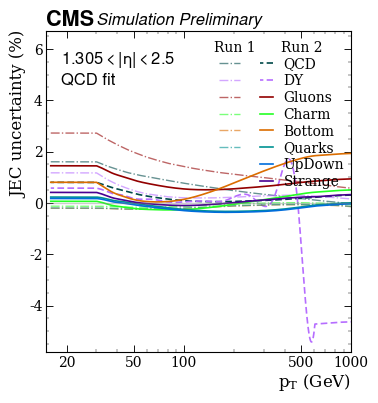

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_QCD_fit_eta2p5to3p139.pdf / .png


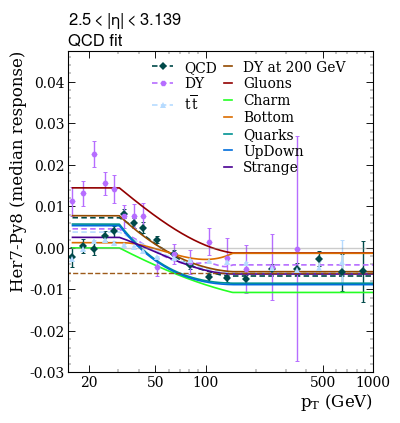

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_25eta3139_QCD_fit.pdf / .png


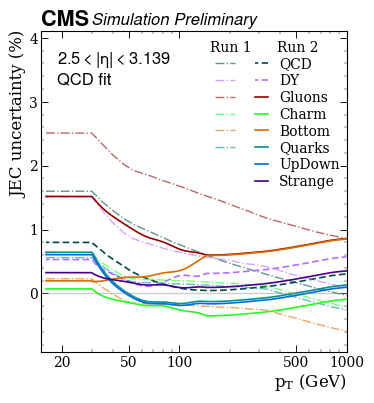

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_QCD_fit_eta3p139to5p191.pdf / .png


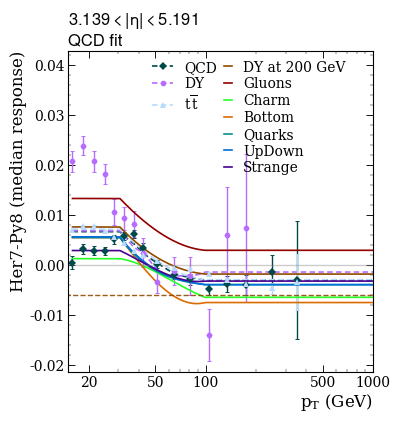

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_3139eta5191_QCD_fit.pdf / .png


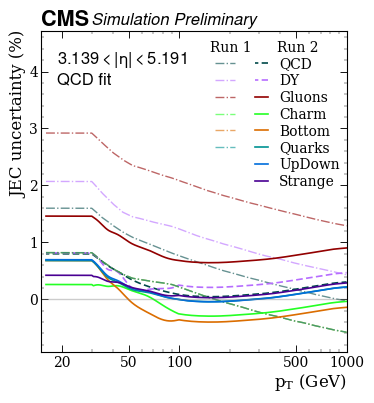

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_16_0_GeV_QCD_fit.pdf / .png


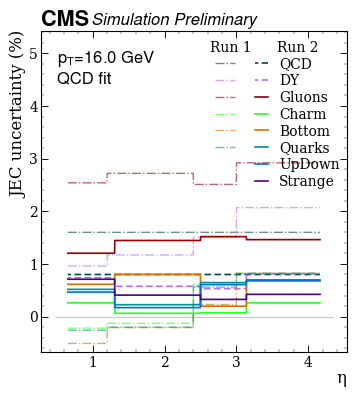

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_21_5_GeV_QCD_fit.pdf / .png


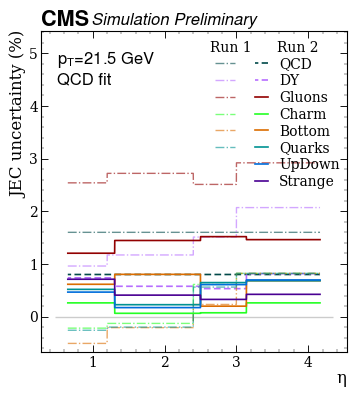

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_32_5_GeV_QCD_fit.pdf / .png


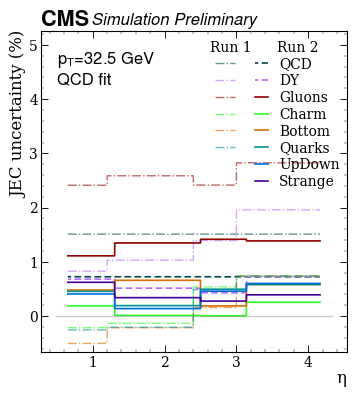

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_51_0_GeV_QCD_fit.pdf / .png


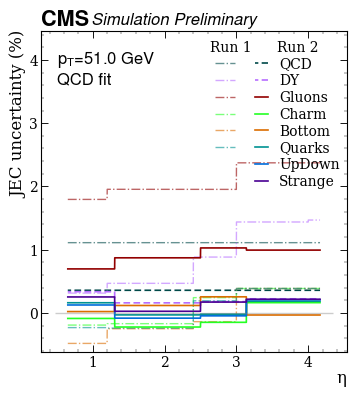

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_105_0_GeV_QCD_fit.pdf / .png


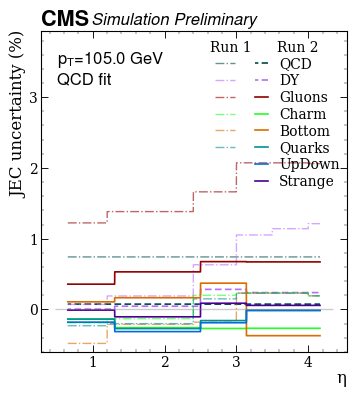

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_350_0_GeV_QCD_fit.pdf / .png


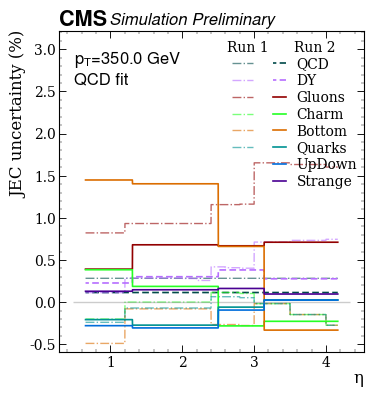

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_650_0_GeV_QCD_fit.pdf / .png


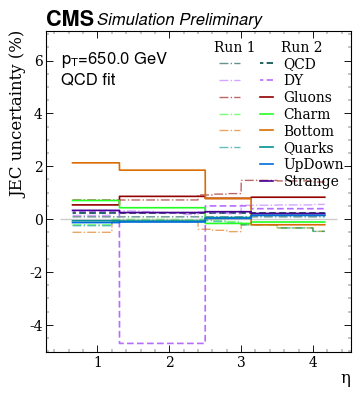

In [39]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
# use_corrections = 'ratio'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the combined fit

if use_corrections=='T':
    pltstr2 = f'\nTTBAR fit'
elif use_corrections=='J':
    pltstr2 = '\nQCD fit'
elif use_corrections=='ratio':
    pltstr2 = '\nRatio simfit'
elif use_corrections=='simfit':
    pltstr2 = '\nCorrection simfit'
else:
    raise ValueError("wrong correction type provided")

correction_txt_mtp = correction_txt_simfit if use_corrections=='simfit' else correction_txt
use_corrections2 = 'J' if use_corrections=='simfit' else use_corrections
if use_corrections=='ratio':
    difference_evaluator = Her_Py_ratio_fit_res
else:
    difference_evaluator = CorrectionEvaluator(binning=eta_binning,
                                        flavors=flavors,
                                        correction_txt_dir=correction_txt_dir,
                                        correction_txt=correction_txt_mtp,
                                        inverse=False,
                                        ptmin_global=ptmin_global,
                                        ptmax_global=ptmax_global,
                                        use_corrections=use_corrections2,
                                       )
        
for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
    if plotvspt:
        ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 10000)
        idx = jeteta_bins.get_bin_idx(plot_val)
        etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
        pt_idxs = range(pt_bins.nbins)
        eta_idxs = idx
    else:    
        etavals = np.linspace(jeteta_bins.centres.min(),jeteta_bins.centres.max(), 10000)
        idx = pt_bins.get_bin_idx(plot_val)
        ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
        pt_idxs = idx
        eta_idxs = range(jeteta_bins.nbins)
    
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
    Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]

        HerPy_spline = difference_evaluator.resum_ratio_to_mix(
                                          etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy
                                        )
        if not combine_antiflavour_txt:
            corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
                                                                  inverse=inverse, divideHerPy=divideHerPy,
                                                                  eta_binning_str=eta_binning_str+combine_antiflavour_txt)

            HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]
        else:
            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      evaluator=difference_evaluator,
                                                                      qfrac_spline_dict=qfrac_spline_dict,
                                                                     divideHerPy=divideHerPy)
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
                       pltstr2, flavors, combine_antiflavour=combine_antiflavour)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
                
        ptoretastr+=pltstr2
        if combine_antiflavour:
            plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
                             ptoretastr, flavors, plotvspt=plotvspt)
        else:
            plot_uncertainty_antiflav(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
                             ptoretastr, flavors, plotvspt=plotvspt)
        

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_Correction_simfit_eta0p0to1p305.pdf / .png


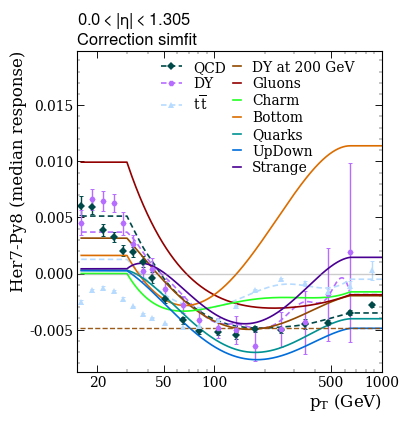

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_00eta1305_Correction_simfit.pdf / .png


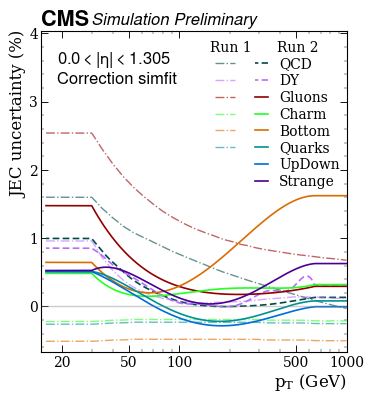

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_Correction_simfit_eta1p305to2p5.pdf / .png


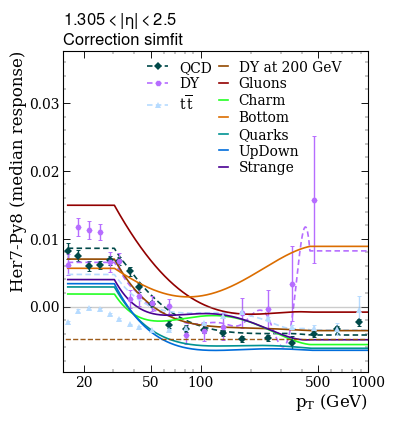

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_1305eta25_Correction_simfit.pdf / .png


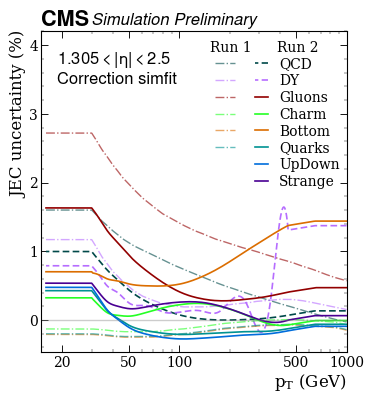

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_Correction_simfit_eta2p5to3p139.pdf / .png


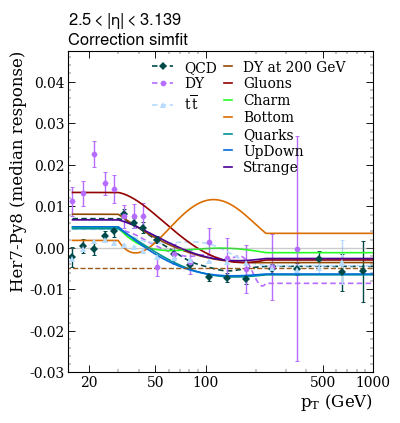

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_25eta3139_Correction_simfit.pdf / .png


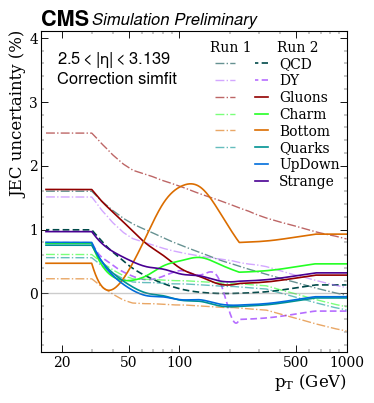

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_Correction_simfit_eta3p139to5p191.pdf / .png


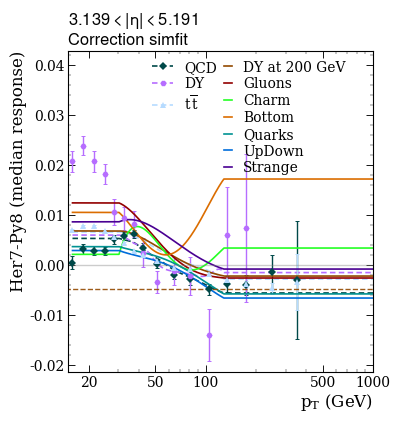

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_3139eta5191_Correction_simfit.pdf / .png


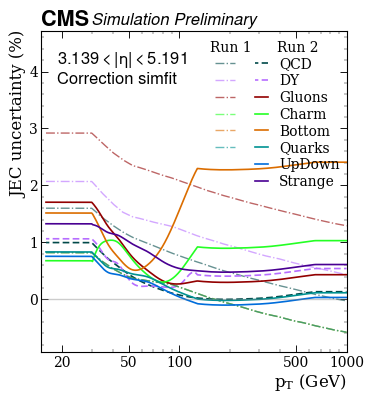

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_16_0_GeV_Correction_simfit.pdf / .png


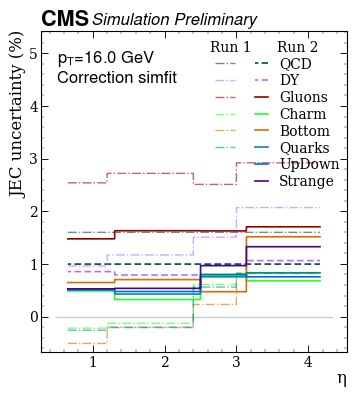

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_21_5_GeV_Correction_simfit.pdf / .png


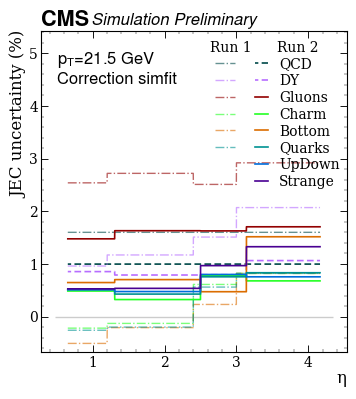

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_32_5_GeV_Correction_simfit.pdf / .png


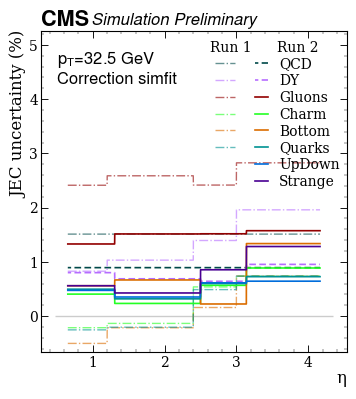

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_51_0_GeV_Correction_simfit.pdf / .png


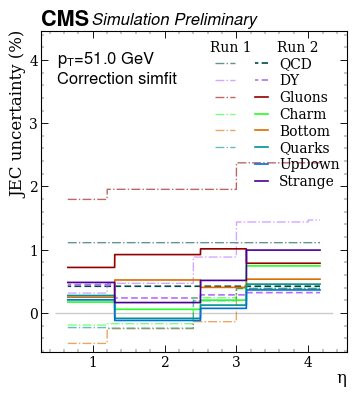

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_105_0_GeV_Correction_simfit.pdf / .png


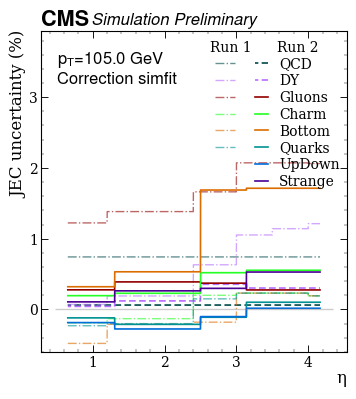

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_350_0_GeV_Correction_simfit.pdf / .png


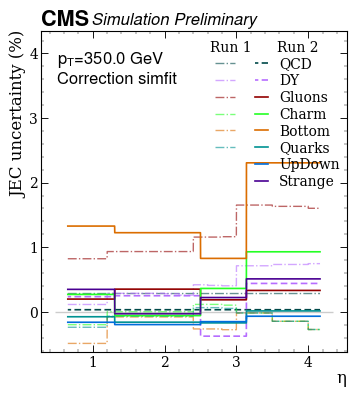

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_p_T_650_0_GeV_Correction_simfit.pdf / .png


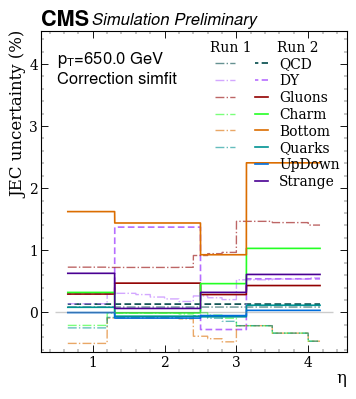

In [108]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
use_corrections = 'simfit'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the combined fit

if use_corrections=='T':
    pltstr2 = f'\nTTBAR fit'
elif use_corrections=='J':
    pltstr2 = '\nQCD fit'
elif use_corrections=='ratio':
    pltstr2 = '\nRatio simfit'
elif use_corrections=='simfit':
    pltstr2 = '\nCorrection simfit'
else:
    raise ValueError("wrong correction type provided")

correction_txt_mtp = correction_txt_simfit if use_corrections=='simfit' else correction_txt
use_corrections2 = 'J' if use_corrections=='simfit' else use_corrections
if use_corrections=='ratio':
    difference_evaluator = Her_Py_ratio_fit_res
else:
    difference_evaluator = CorrectionEvaluator(binning=eta_binning,
                                        flavors=flavors,
                                        correction_txt_dir=correction_txt_dir,
                                        correction_txt=correction_txt_mtp,
                                        inverse=False,
                                        ptmin_global=ptmin_global,
                                        ptmax_global=ptmax_global,
                                        use_corrections=use_corrections2,
                                       )
        
for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
    if plotvspt:
        ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 10000)
        idx = jeteta_bins.get_bin_idx(plot_val)
        etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
        pt_idxs = range(pt_bins.nbins)
        eta_idxs = idx
    else:    
        etavals = np.linspace(jeteta_bins.centres.min(),jeteta_bins.centres.max(), 10000)
        idx = pt_bins.get_bin_idx(plot_val)
        ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
        pt_idxs = idx
        eta_idxs = range(jeteta_bins.nbins)
    
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
    Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]

        HerPy_spline = difference_evaluator.resum_ratio_to_mix(
                                          etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy
                                        )
        if not combine_antiflavour_txt:
            corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
                                                                  inverse=inverse, divideHerPy=divideHerPy,
                                                                  eta_binning_str=eta_binning_str+combine_antiflavour_txt)

            HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]
        else:
            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      evaluator=difference_evaluator,
                                                                      qfrac_spline_dict=qfrac_spline_dict,
                                                                     divideHerPy=divideHerPy)
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
                       pltstr2, flavors, combine_antiflavour=combine_antiflavour)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
                
        ptoretastr+=pltstr2
        if combine_antiflavour:
            plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
                             ptoretastr, flavors, plotvspt=plotvspt)
        else:
            plot_uncertainty_antiflav(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
                             ptoretastr, flavors, plotvspt=plotvspt)
        

In [ ]:
additional_uncertainty_curves

In [ ]:
difference_evaluator.get_limits('Py', 'b', [0,1,10])
difference_evaluator.get_limits('Her', 'b', [0,1,10])
difference_evaluator.get_limits_all_flav([0,1,10])

### Run in the bins of the uncertainty files

In [ ]:
jeteta_bins_unc = JetEtaBins("Uncert", absolute=True)
pt_bins_unc = PtBins("Uncert")

# jeteta_bins_unc = JetEtaBins("HCalPart", absolute=True)
# pt_bins_unc = PtBins("MC_truth")

In [ ]:
ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins_unc.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)

inverse = False
divideHerPy = False #True
plotvspt = True
# use_corrections = 'T'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the combined fit

if use_corrections=='T':
    pltstr2 = f'\nTTBAR fit'
elif use_corrections=='J':
    pltstr2 = f'\nQCD fit'
elif use_corrections=='ratio':
    pltstr2 = f'\nCombined fit'
else:
    raise ValueError("wrong correction type provided")

if use_corrections=='ratio':
    difference_evaluator = Her_Py_ratio_fit_res
else:
    difference_evaluator = CorrectionEvaluator(binning=eta_binning,
                                        flavors=flavors,
                                        correction_txt_dir=correction_txt_dir,
                                        correction_txt=correction_txt,
                                        inverse=False,
                                        ptmin_global=ptmin_global,
                                        ptmax_global=ptmax_global,
                                        use_corrections=use_corrections,
                                       )
    
uncert_to_save = {flav: np.array([None]*pt_bins_unc.nbins) for flav in flavors}
for plot_val in plot_vals:
    ptvals = pt_bins_unc.centres
    idx = jeteta_bins_unc.get_bin_idx(plot_val)
    etavals = np.ones(len(ptvals))*jeteta_bins_unc.centres[idx]
    pt_idxs = range(pt_bins_unc.nbins)
    eta_idxs = idx
#     else:    
#         etavals = np.linspace(jeteta_bins_unc.centres.min(),jeteta_bins_unc.centres.max(), 10000)
#         idx = pt_bins_unc.get_bin_idx(plot_val)
#         ptvals = np.ones(len(etavals))*pt_bins_unc.centres[idx]
#         pt_idxs = idx
#         eta_idxs = range(jeteta_bins_unc.nbins)
    
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins_unc.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
    Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]

        HerPy_spline = difference_evaluator.resum_ratio_to_mix(
                                          etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy
                                        )
        if not combine_antiflavour_txt:
#             corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
#                                                                   inverse=inverse, divideHerPy=divideHerPy,
#                                                                   eta_binning_str=eta_binning_str+combine_antiflavour_txt)

            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]
        else:
            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      evaluator=difference_evaluator,
                                                                      qfrac_spline_dict=qfrac_spline_dict,
                                                                     divideHerPy=divideHerPy)
    for flav in flavors:
        if combine_antiflavour:
            uncert_to_save[flav] = np.vstack([uncert_to_save[flav],
                                              additional_uncertainty_curves[flav+'100']-additional_uncertainty_curves['Rref']])
        else:
            uncert_to_save[flav] = np.vstack([uncert_to_save[flav],
                                              additional_uncertainty_curves[flav+'100']])
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        ptoretastr = jeteta_bins_unc.idx2plot_str(idx)
                
        ptoretastr+=pltstr2
        if combine_antiflavour:
            plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
                             ptoretastr, flavors, plotvspt=True)
        else:
            plot_uncertainty_antiflav(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
                             ptoretastr, flavors, plotvspt=True)
for flav in flavors:
    uncert_to_save[flav] = uncert_to_save[flav][1:]

In [ ]:
flavor_unc_name_dict = {'g': 'PureGluon', 'c': 'PureCharm', 'b':'PureBottom', 'ud':'PureUpDown',
                        'q':'PureQuark', 's':'PureStrange',
                        'cbar': 'PureAntiCharm', 'bbar':'PureAntiBottom', 'udbar':'PureAntiUpDown',
                        'qbar':'PureAntiQuark', 'sbar':'PureAntiStrange'}

In [ ]:
# [jeteta_bins_unc.edges[0], jeteta_bins_unc.edges[1]]
new_uncertainties = {}
for flav in flavors:
    name = flavor_unc_name_dict[flav] 
    neg_etabins = [[-jeteta_bins_unc.edges[idx+1], -jeteta_bins_unc.edges[idx], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins-1, -1, -1)]
    
    pos_etabins = [[jeteta_bins_unc.edges[idx], jeteta_bins_unc.edges[idx+1], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins)]
    new_uncertainties ['Flavor'+name] = np.array(neg_etabins + pos_etabins)
    
    
    

In [ ]:
round_int = 4 if combine_antiflavour else 5

def update_flavor_uncertainty_file(file_path, new_uncertainties):
    matched_section = False
    with open(file_path, 'r') as file:
        lines = file.readlines()

    output_lines = []
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.startswith("["):
            section_title = line.strip()[1:-1]
            matched_section = section_title in new_uncertainties
            if matched_section:
                if 'PureQuark' in section_title and add_composed_flav:
                    new_section_titles = ["FlavorPureQuark", "FlavorPureUpDown", "FlavorPureStrange"]
                else:
                    new_section_titles = [section_title]
                for section_title in new_section_titles:
                    print('replacing or adding a new section secion:', section_title)
                    output_lines.append(f'[{section_title}]\n')
                    output_lines.append('{1 JetEta 1 JetPt "" Correction JECSource} \n')
                    values = new_uncertainties[section_title]
                    for value_row in values:
    #                     output_lines.append(value_row+'\n')
                        output_lines.append(' '.join(map(str, np.round(value_row, round_int))) + '\n')

    #                     output_lines.append('\n'.join(map(str, value_row)) + '\n')
                i += len(values)
            else:
                print('copying secion:', section_title)
                output_lines.append(line)
        elif not matched_section:
            output_lines.append(line)
        i += 1
    outfilename = file_path[:-4]+'_run2flavor.txt'
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)

In [ ]:
def update_flavor_antiflavor_uncertainty_file(file_path, new_uncertainties):
    output_lines = []
    for section_title in new_uncertainties:
        output_lines.append(f'[{section_title}]\n')
        output_lines.append('{1 JetEta 1 JetPt "" Correction JECSource} \n')
        values = new_uncertainties[section_title]
        for value_row in values:
            output_lines.append(' '.join(map(str, np.round(value_row,round_int))) + '\n')

    outfilename = file_path[:-4]+'_run2flavor_antiflavor.txt'
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)

In [ ]:
if combine_antiflavour:
    update_flavor_uncertainty_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt', new_uncertainties)
else:
    update_flavor_antiflavor_uncertainty_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt', new_uncertainties)